# Allgemeines

## Begriffe

Statistische Einheit
Grundgesamtheit
Stichprobe
Merkmal
Ausprägung


qualitativ und quantitativ
nominal ordinal diskret stetig


## Unvariante Statistik

1. Rohdatenanalyse graphisch und beschreibend
    - Scatterplot 
    - Zeitreihenanalyse (bspw. Durchschnitt über mehrere Jahre)
        - Trend, Saisonalität, Rauschen
        - gleitender Mittelwert
2. Absolute und relative Häufigkeit
    - Histogram: Wochentage oder Monatstage mit Anzahl als Histogram
    - empirische Verteilungsfunktion
3. Statistische Kennzahlen
    - Median
    - Boxplot
    - Violin-Plot

## Multivariante Statistik

1. Scatterplot auf 2 Achsen
2. Korrelation
    - Scatterplot / Heatmap
3. Lineare Regression
4. Vorhersage


In [ ]:
# Basics
# Auslesen der Werte aus dem Datensatz
import pandas as pd
import matplotlib.pyplot as plt
import csv

def extract_csv_data(file_path, field_name):
    with open(file_path, mode='r', newline='', encoding='utf-8') as file:
        reader = csv.DictReader(file)
        # print(reader.fieldnames)
        data = [row[field_name] for row in reader if row[field_name]]
    return data

# CSV-Datei laden (ersetze 'daten.csv' durch den tatsächlichen Dateipfad)
csv_file = './data/Fahrraeder_taeglich.csv'
# csv_file = 'data.csv'
raeder = extract_csv_data(csv_file, 'Raeder')
einwaerts = extract_csv_data(csv_file, 'stadteinwaerts')
auswaerts = extract_csv_data(csv_file, 'stadtauswaerts')
temp = extract_csv_data(csv_file, 'GefuehlteTemperatur')
regen = extract_csv_data(csv_file, 'Regen')
zeit = extract_csv_data(csv_file, 'Zeit')

zeit_dt = pd.to_datetime(zeit, format='%d.%m.%Y %H:%M')
raeder = [float(x) for x in raeder]
temp = [float(x) for x in temp]
einwaerts = [float(x) for x in einwaerts]
auswaerts = [float(x) for x in auswaerts]
regen = [float(x) for x in regen]

proTag = [r - (e + a) for r, e, a in zip(raeder, einwaerts, auswaerts)]

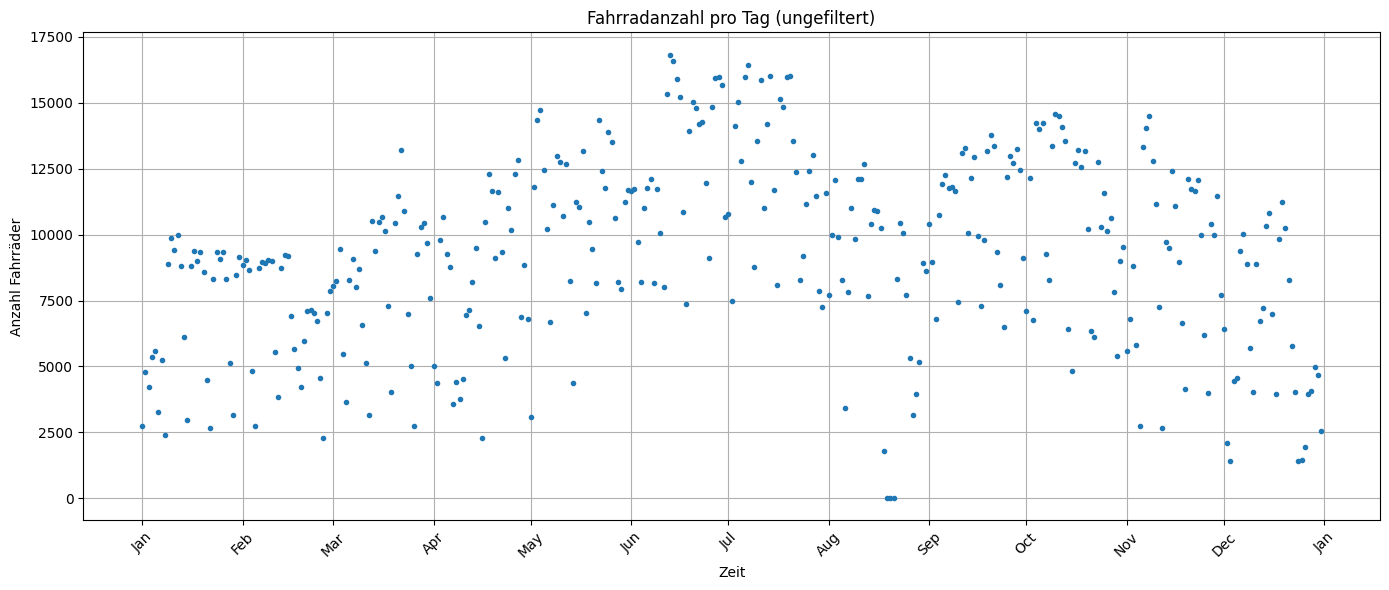

In [ ]:
# 1.Rohdatenanalyse

# Plotten der Anzahl vs. Zeit
import matplotlib.dates as mdates

plt.figure(figsize=(14, 6))
plt.plot(zeit, raeder, marker='o', linestyle='none', markersize=3)
plt.title('Fahrradanzahl pro Tag (ungefiltert)')
plt.xlabel('Zeit')
plt.ylabel('Anzahl Fahrräder')
plt.grid(True)

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=10, maxticks=15))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
# 1.2 Zeitreihenanalyse

...

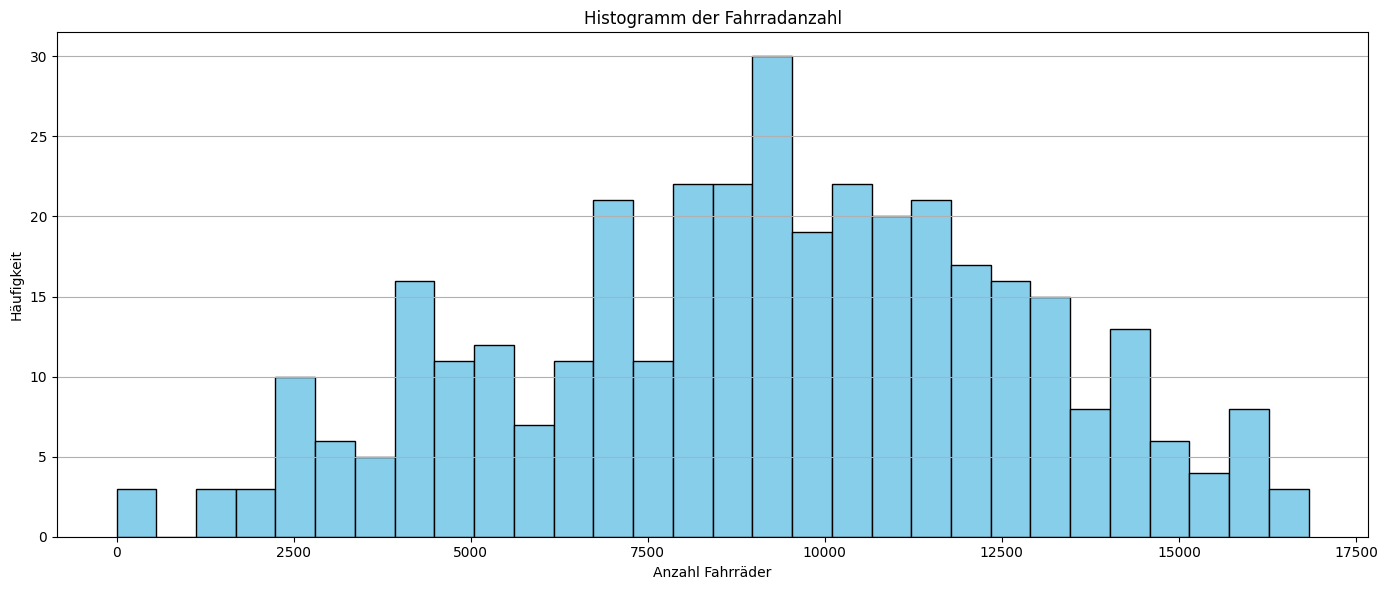

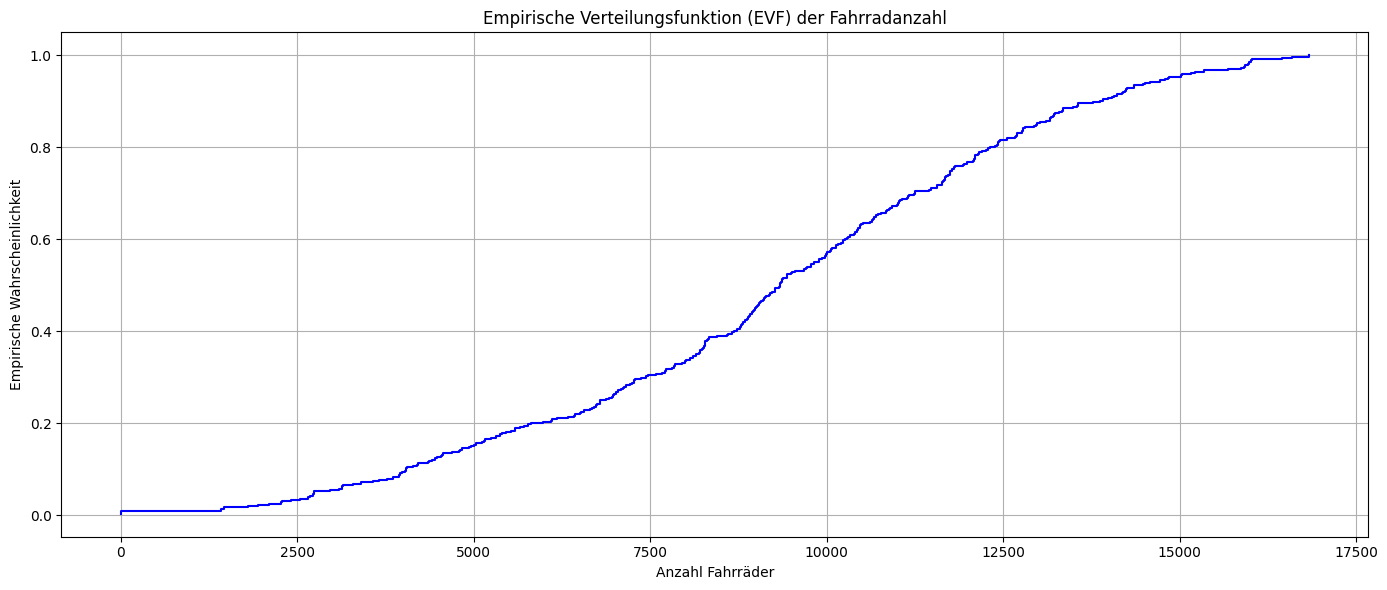

In [ ]:
# 2. Absolute und Relative Häufigkeiten
import matplotlib.pyplot as plt

# Histogram
plt.figure(figsize=(14, 6))
plt.hist(raeder, bins=30, color='skyblue', edgecolor='black')
plt.title('Histogramm der Fahrradanzahl')
plt.xlabel('Anzahl Fahrräder')
plt.ylabel('Häufigkeit')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


# Empirische Verteilungsfunktion
werte = np.sort(raeder)
n = len(werte)
y = np.arange(1, n + 1) / n

plt.figure(figsize=(14, 6))
plt.step(werte, y, where='post', color='blue')
plt.title('Empirische Verteilungsfunktion (EVF) der Fahrradanzahl')
plt.xlabel('Anzahl Fahrräder')
plt.ylabel('Empirische Wahrscheinlichkeit')
plt.grid(True)
plt.tight_layout()
plt.show()

Mean: 9198.715068493151
Median: 9339.0
Modalwert: 0
25%-Quantil: 6878.0
75%-Quantil: 11780.0
Standardabweichung: 3583.7611513631273
Varianz: 12843343.990019567


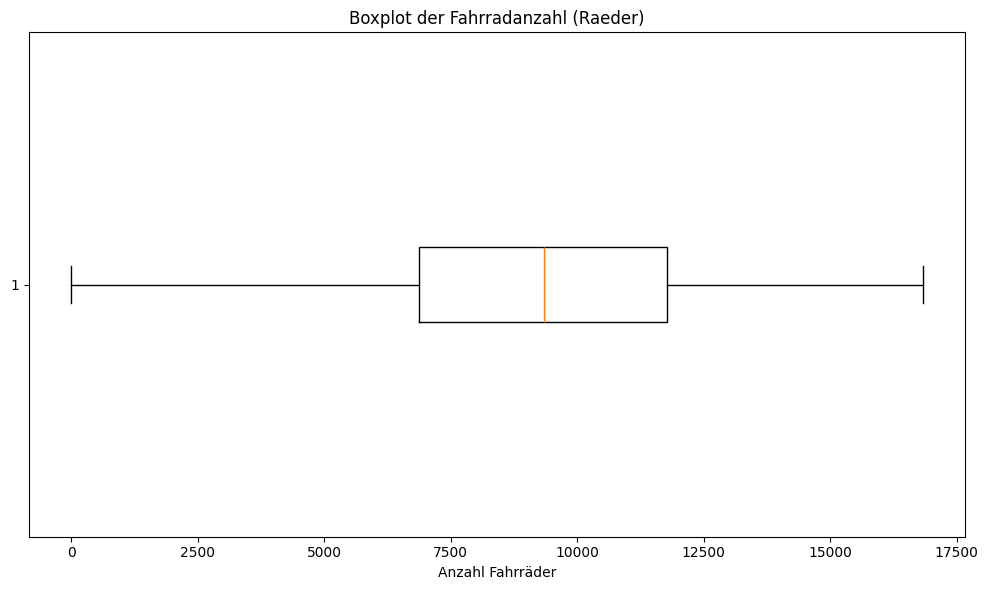

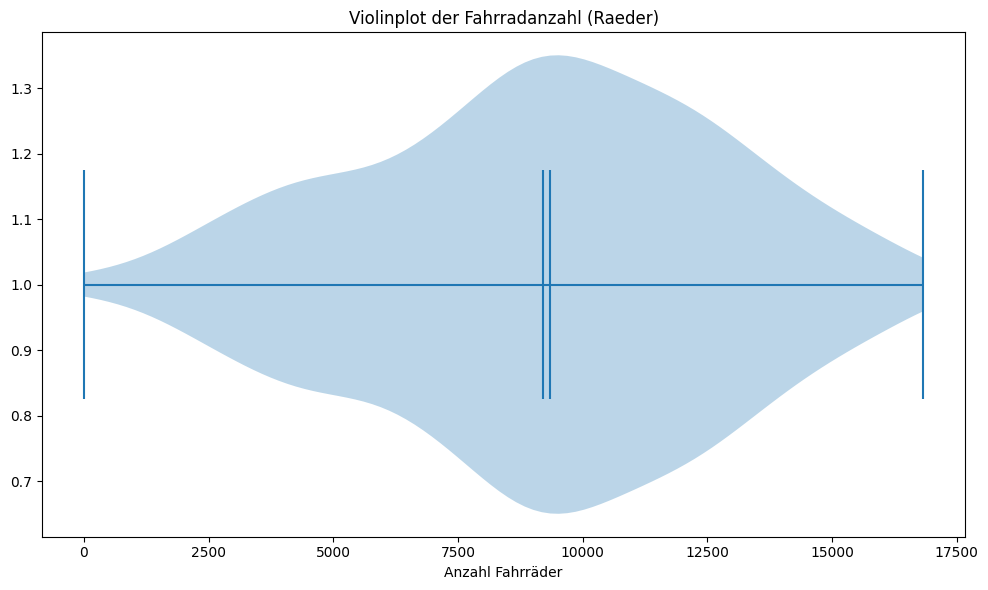

In [ ]:
# 3. Statische Kennzahlen

import numpy as np
import matplotlib.pyplot as plt

# Statistische Kennwerte berechnen
werte = np.array(raeder, dtype=float)

median = np.median(werte)
mean = np.mean(werte)
modalwert = np.bincount(werte.astype(int)).argmax()
quantile_25 = np.quantile(werte, 0.25)
quantile_75 = np.quantile(werte, 0.75)
standardabweichung = np.std(werte, ddof=1)
varianz = np.var(werte, ddof=1)

# Kennzahlen
print("Mean:", mean)
print("Median:", median)
print("Modalwert:", modalwert)
print("25%-Quantil:", quantile_25)
print("75%-Quantil:", quantile_75)
print("Standardabweichung:", standardabweichung)
print("Varianz:", varianz)

# Boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(werte, vert=False)
plt.title('Boxplot der Fahrradanzahl (Raeder)')
plt.xlabel('Anzahl Fahrräder')
plt.tight_layout()
plt.show()

# Violin-Plot
plt.figure(figsize=(10, 6))
plt.violinplot(werte, vert=False, widths=0.7, showmeans=True, showmedians=True)
plt.title('Violinplot der Fahrradanzahl (Raeder)')
plt.xlabel('Anzahl Fahrräder')
plt.tight_layout()
plt.show()

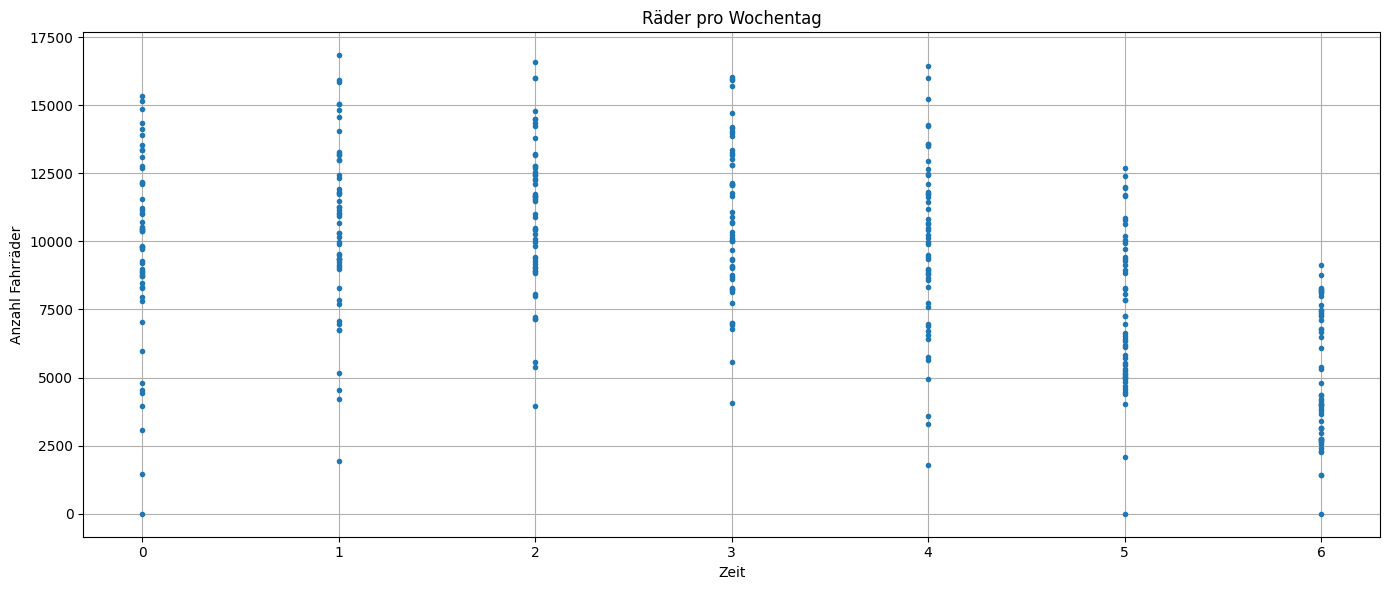

Pearson Correlation between Weekday and Raeder: -0.4373733376799042


In [6]:
from scipy.stats import pearsonr

weekdays = zeit_dt.weekday  # 0=Monday, 1=Tuesday, ..., 6=Sunday

# Calculate Pearson correlation
correlation, _ = pearsonr(weekdays, raeder)

plt.figure(figsize=(14, 6))
plt.plot(weekdays, raeder, marker='o', linestyle='none', markersize=3)
plt.title('Räder pro Wochentag')
plt.xlabel('Zeit')
plt.ylabel('Anzahl Fahrräder')
plt.grid(True)
plt.tight_layout()
plt.show()

print("Pearson Correlation between Weekday and Raeder:", correlation)

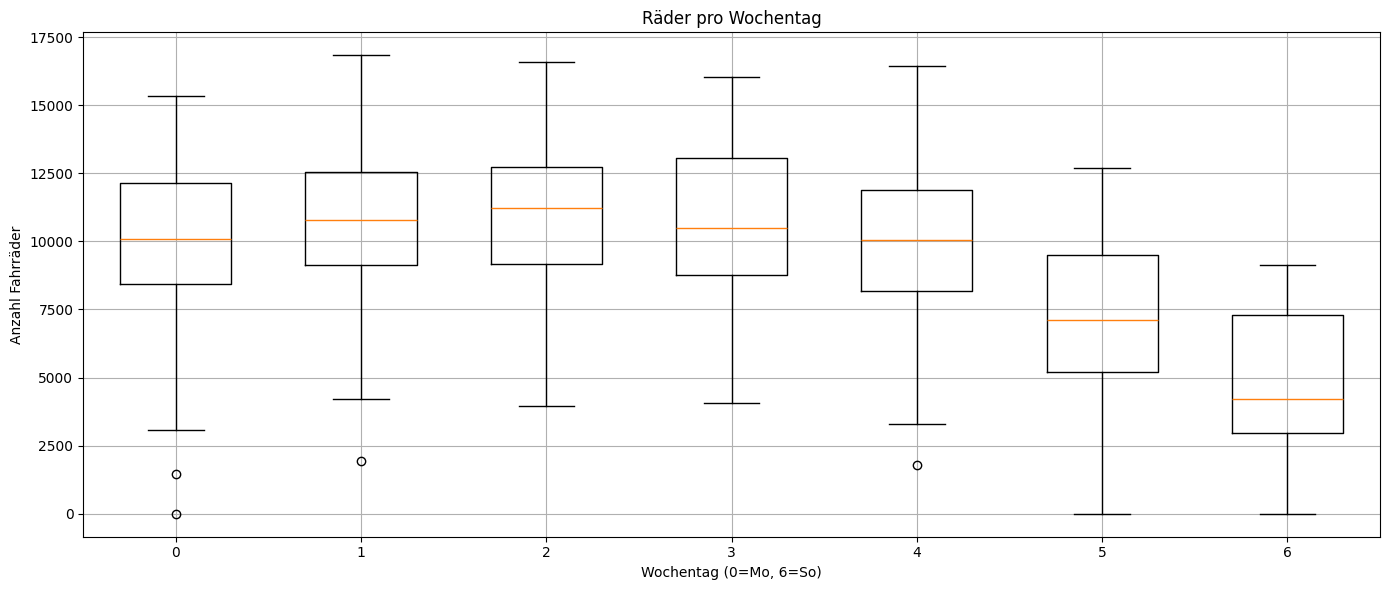

Pearson Correlation between Weekday and Raeder: -0.4373733376799042


In [7]:
import matplotlib.pyplot as plt

# Group data by weekday
import pandas as pd
data = pd.DataFrame({'weekday': zeit_dt.weekday, 'raeder': raeder})
grouped = [group['raeder'].values for _, group in data.groupby('weekday')]

# Pearson correlation
from scipy.stats import pearsonr
correlation, _ = pearsonr(zeit_dt.weekday, raeder)

# Plot
plt.figure(figsize=(14, 6))
plt.boxplot(grouped, positions=range(7), widths=0.6)
plt.title('Räder pro Wochentag')
plt.xlabel('Wochentag (0=Mo, 6=So)')
plt.ylabel('Anzahl Fahrräder')
plt.grid(True)
plt.tight_layout()
plt.show()

print("Pearson Correlation between Weekday and Raeder:", correlation)

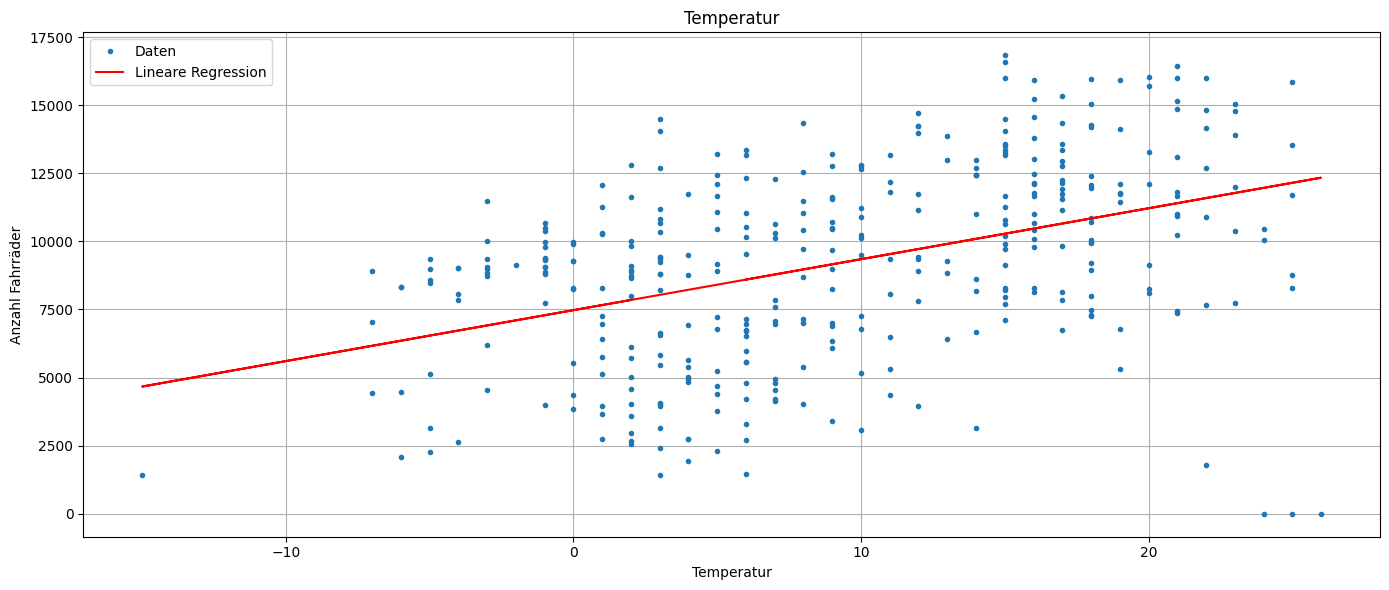

Pearson Correlation between Temperature and Raeder: 0.4258805266190003


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Pearson correlation
correlation, _ = pearsonr(temp, raeder)

# Linear regression
slope, intercept = np.polyfit(temp, raeder, 1)
regression_line = np.poly1d((slope, intercept))

# Plot
plt.figure(figsize=(14, 6))
plt.plot(temp, raeder, marker='o', linestyle='none', markersize=3, label='Daten')
plt.plot(temp, regression_line(temp), color='red', label='Lineare Regression')
plt.title('Temperatur')
plt.xlabel('Temperatur')
plt.ylabel('Anzahl Fahrräder')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print("Pearson Correlation between Temperature and Raeder:", correlation)

[0.0, 0.0, 1.1, 0.0, 0.9, 0.0, 0.0, 0.1, 3.4, 0.3, 0.6, 1.5, 0.9, 0.2, 1.6, 0.0, 0.3, 0.8, 0.1, 1.0, 0.2, 0.3, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.1, 0.4, 3.9, 0.4, 0.0, 0.2, 0.8, 0.4, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.2, 0.3, 0.8, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.8, 26.6, 9.3, 5.1, 6.0, 7.8, 14.2, 2.8, 0.0, 0.0, 0.0, 8.8, 0.0, 0.0, 0.0, 4.2, 9.6, 6.4, 12.6, 4.4, 0.0, 0.0, 9.8, 17.5, 9.8, 16.1, 1.8, 0.0, 0.0, 0.0, 30.2, 6.5, 0.5, 0.0, 3.4, 5.5, 3.0, 4.9, 0.1, 22.1, 5.7, 1.3, 6.0, 18.3, 1.5, 0.1, 13.0, 9.5, 13.0, 4.7, 0.1, 12.8, 3.7, 0.3, 1.4, 1.7, 0.0, 0.0, 1.4, 1.5, 9.0, 17.7, 12.6, 30.7, 2.2, 9.6, 0.2, 1.0, 4.4, 3.2, 0.1, 0.0, 0.0, 0.4, 7.1, 10.5, 8.2, 1.1, 0.9, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8, 0.1, 0.1, 0.6, 0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.8, 21.2, 1.5, 11.4, 0.2, 0.0, 0.0, 0.1, 0.1, 0.0, 0.0, 24.9, 6.6, 0.3, 0.1, 3.5, 3.0, 0.1, 0.0, 0.0, 0.0, 0.8, 10.0, 16.5, 8.2, 0.0, 0.9

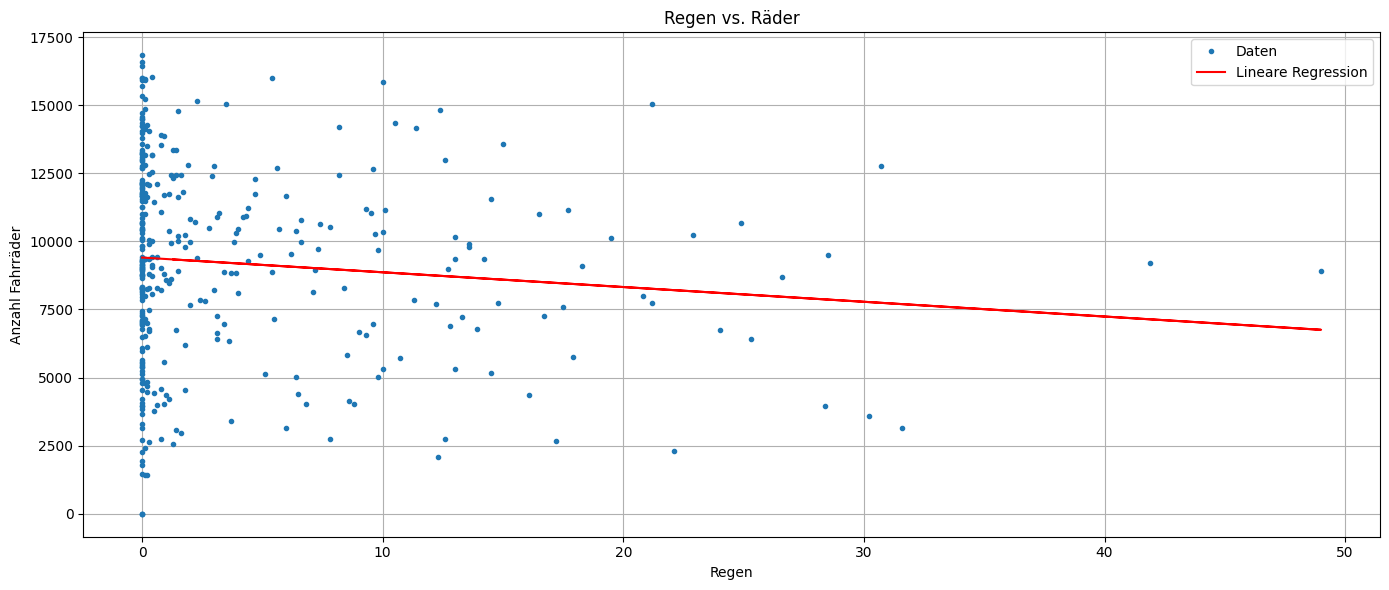

Pearson Correlation between Regen and Raeder: -0.10564860863985842


In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Pearson correlation
print(regen)
correlation, _ = pearsonr(regen, raeder)

# Linear regression
slope, intercept = np.polyfit(regen, raeder, 1)
regression_line = np.poly1d((slope, intercept))

# Plot
plt.figure(figsize=(14, 6))
plt.plot(regen, raeder, marker='o', linestyle='none', markersize=3, label='Daten')
plt.plot(regen, regression_line(regen), color='red', label='Lineare Regression')
plt.title('Regen vs. Räder')
plt.xlabel('Regen')
plt.ylabel('Anzahl Fahrräder')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print("Pearson Correlation between Regen and Raeder:", correlation)